<a href="https://colab.research.google.com/github/nik0laygavrIlov/DA_ML_repo/blob/main/CIFAR10_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Проводится обучение модели сверточной нейронной сети (СNN) по распознаванию изображений датасета CIFAR10

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
from keras.initializers import HeUniform
from keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
(X_train, y_train), (X_val, y_val) = tf.keras.datasets.cifar10.load_data()
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, random_state=42, test_size=0.5, stratify=y_val)

Кодируем метки в one-hot представление

In [ ]:
y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

In [ ]:
X_train[0].shape

(32, 32, 3)

In [ ]:
y_train.shape

(50000, 1)

Выведем примеры картинок

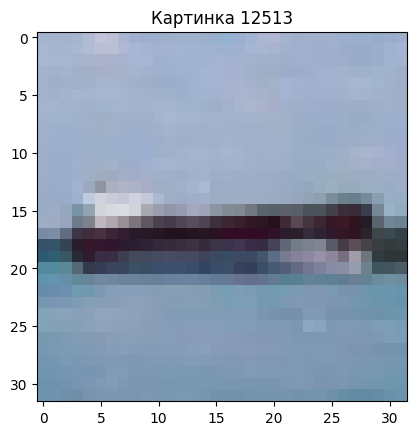

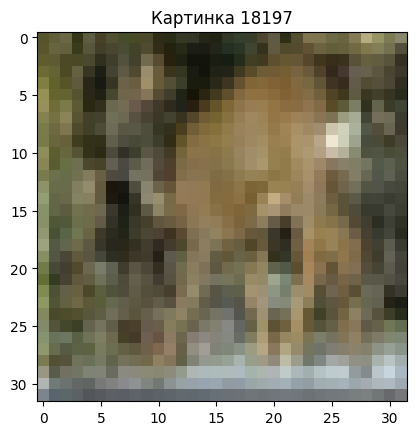

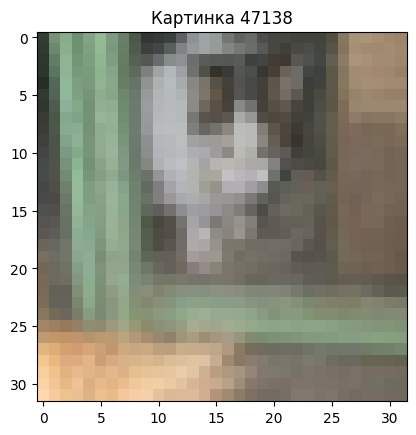

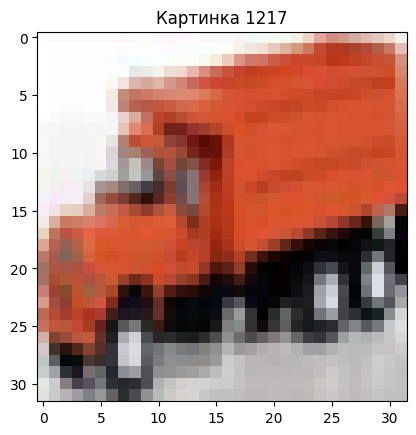

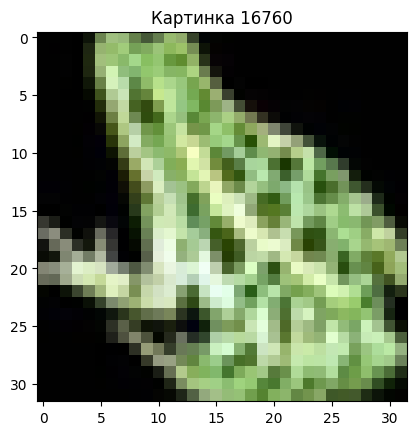

In [ ]:
for x in np.random.choice(len(X_train) - 1, 5):
  plt.imshow(X_train[x])
  plt.title(f'Картинка {x}')
  plt.show()

In [ ]:
y_train_ = y_train.reshape(50000).astype('int')

<Axes: ylabel='count'>

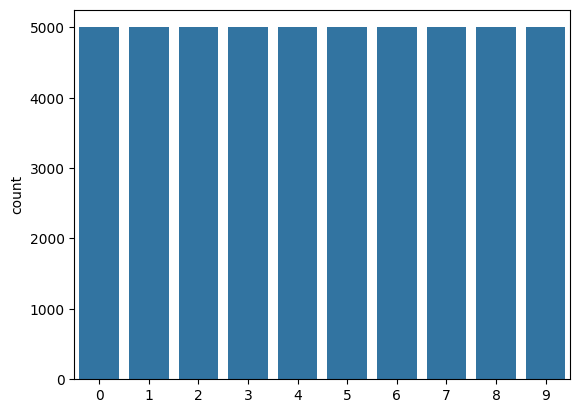

In [ ]:
sns.countplot(x=y_train_)

Как видим, датасет у нас сбалансирован, поэтому используем обычную hold-out валидацию

Нормализуем данные и собираем модель

In [ ]:
layer = keras.layers.Normalization(axis=None)
layer.adapt(X_train)
X_train_norm = layer(X_train)
X_val_norm = layer(X_val)
X_test_norm = layer(X_test)

In [ ]:
model = Sequential()

model.add(L.Conv2D(32, (3, 3), activation='selu', kernel_initializer="glorot_uniform", padding='same', input_shape=(32, 32, 3)))
model.add(L.BatchNormalization())
model.add(L.Dropout(0.3))

model.add(L.MaxPooling2D(pool_size=(2, 2)))

model.add(L.Conv2D(16, (3, 3), activation='selu', kernel_initializer="glorot_uniform", padding='same'))
model.add(L.BatchNormalization())
model.add(L.Dropout(0.3))

model.add(L.MaxPooling2D(pool_size=(2, 2)))

model.add(L.Flatten())

model.add(L.Dense(128, kernel_initializer=HeUniform(), activation='selu'))
model.add(L.BatchNormalization())
model.add(L.Dropout(0.5))

model.add(L.Dense(64, kernel_initializer=HeUniform(), activation='selu'))
model.add(L.BatchNormalization())
model.add(L.Dropout(0.5))

model.add(L.Dense(32, kernel_initializer=HeUniform(), activation='selu'))
model.add(L.BatchNormalization())
model.add(L.Dropout(0.5))

model.add(L.Dense(10, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        4624      
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 16)        6

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    min_delta=0.005,
    restore_best_weights=True
)

In [ ]:
history = model.fit(
                      X_train_norm,
                      y_train_oh,
                      batch_size=64,
                      epochs=30,
                      validation_data=(X_val_norm, y_val_oh),
                      callbacks=[early_stopping]
                    )

Epoch 1/30
782/782 [==============================] - 21s 24ms/step - loss: 1.9823 - accuracy: 0.2973 - val_loss: 1.7917 - val_accuracy: 0.3674
Epoch 2/30
782/782 [==============================] - 19s 24ms/step - loss: 1.5488 - accuracy: 0.4371 - val_loss: 1.5954 - val_accuracy: 0.4434
Epoch 3/30
782/782 [==============================] - 19s 24ms/step - loss: 1.4018 - accuracy: 0.5016 - val_loss: 1.5478 - val_accuracy: 0.4720
Epoch 4/30
782/782 [==============================] - 19s 24ms/step - loss: 1.3181 - accuracy: 0.5408 - val_loss: 1.4484 - val_accuracy: 0.4914
Epoch 5/30
782/782 [==============================] - 19s 25ms/step - loss: 1.2571 - accuracy: 0.5664 - val_loss: 1.3933 - val_accuracy: 0.5316
Epoch 6/30
782/782 [==============================] - 18s 23ms/step - loss: 1.2217 - accuracy: 0.5814 - val_loss: 1.2954 - val_accuracy: 0.5620
Epoch 7/30
782/782 [==============================] - 19s 24ms/step - loss: 1.1851 - accuracy: 0.5978 - val_loss: 1.2515 - val_accuracy:

In [ ]:
y_pred = model.predict(X_test_norm)

157/157 [==============================] - 1s 4ms/step


In [ ]:
y_pred = np.argmax(model.predict(X_test_norm), axis = 1)

157/157 [==============================] - 1s 4ms/step


In [ ]:
print('Test Accuracy: ', accuracy_score(y_test, y_pred))

Test Accuracy:  0.643


Нам удалось достичь точности 64 %. Для последовательной сети это неплохой результат. Сеть обучается стабильно, успешно выбираясь из оверфиттинга. Это обусловлено применением дропаута и батч-нормализации на каждом слое, инициализации и пулинга.